# doble LSTM  mecanismo de atención y capas densas


In [1]:

import pandas as pd
from csv import reader
import numpy as np
#from google.colab import drive
#drive.mount('/content/gdrive')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM
from keras_self_attention import SeqWeightedAttention


import matplotlib.pyplot as plot
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

pd.set_option('display.max_columns', 50)
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)


2.6.0
2.6.0


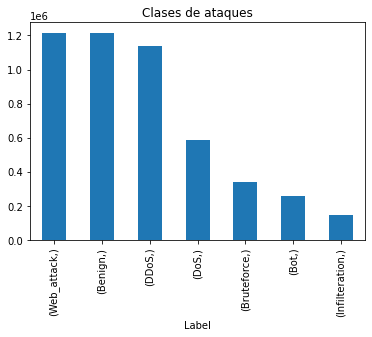

In [2]:
data = pd.read_csv("../Clustering/X_smote.csv",sep=",")
data.columns=['Dst Port',' Protocol',' Flow Duration',' Tot Fwd Pkts',' Tot Bwd Pkts',' TotLen Fwd Pkts',' TotLen Bwd Pkts',' Fwd Pkt Len Max',' Fwd Pkt Len Min',' Fwd Pkt Len Mean',' Fwd Pkt Len Std',' Bwd Pkt Len Max',' Bwd Pkt Len Min',' Bwd Pkt Len Mean',' Bwd Pkt Len Std',' Flow Byts/s',' Flow Pkts/s',' Flow IAT Mean',' Flow IAT Std',' Flow IAT Max',' Flow IAT Min',' Fwd IAT Tot',' Fwd IAT Mean',' Fwd IAT Std',' Fwd IAT Max',' Fwd IAT Min',' Bwd IAT Tot',' Bwd IAT Mean',' Bwd IAT Std',' Bwd IAT Max',' Bwd IAT Min',' Fwd PSH Flags',' Bwd PSH Flags',' Fwd URG Flags',' Bwd URG Flags',' Fwd Header Len',' Bwd Header Len',' Fwd Pkts/s',' Bwd Pkts/s',' Pkt Len Min',' Pkt Len Max',' Pkt Len Mean',' Pkt Len Std',' Pkt Len Var',' FIN Flag Cnt',' SYN Flag Cnt',' RST Flag Cnt',' PSH Flag Cnt',' ACK Flag Cnt',' URG Flag Cnt',' CWE Flag Count',' ECE Flag Cnt',' Down/Up Ratio',' Pkt Size Avg',' Fwd Seg Size Avg',' Bwd Seg Size Avg',' Fwd Byts/b Avg',' Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',' Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts',' Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',' Active Min', 'Idle Mean', 'Idle Std', 'Idle Max','Idle Min']
y = pd.read_csv("../Clustering/y_smote.csv",sep=",")
plot = y.value_counts().plot(kind='bar',title='Clases de ataques')


In [3]:
X=data
y=y.replace (['DDOS attack-LOIC-UDP', 'DDOS attack-HOIC','DDoS attacks-LOIC-HTTP'],'DDoS')
y=y.replace (['Brute Force -Web', 'Brute Force -XSS', 'SQL Injection'],'Web_attack')
y=y.replace (['FTP-BruteForce', 'SSH-Bruteforce'],'Bruteforce')
y=y.replace (['DoS attacks-GoldenEye', 'DoS attacks-Slowloris', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk'],'DoS')

feats = X.shape[1]

In [5]:
X=data

print (pd.unique(y.squeeze()))
print(X.index[np.isinf(X).any(1)])
print(X.isna().values.any())
print (X.shape)

['Bruteforce' 'DoS' 'Benign' 'DDoS' 'Bot' 'Infilteration' 'Web_attack']
Int64Index([], dtype='int64')
False
(4902609, 78)


In [6]:
X_Val=pd.read_csv("../Clustering/X_Val.csv",sep=',',dtype=np.float32)
y_Val=pd.read_csv("../Clustering/y_Val.csv",sep=',')
print (pd.unique(y_Val.squeeze()))
print (y_Val.shape)
print (X_Val.shape)
indices=y_Val[y_Val['Label'] == 'Label'].index
print (indices)

y_Val.drop(indices, inplace=True)
X_Val.drop(indices, inplace=True)

print (y_Val.shape)
print (X_Val.shape)
cant_clases = pd.unique(y_Val.squeeze())
print (cant_clases)

['Benign' 'DoS' 'DDoS' 'Bruteforce' 'Bot' 'Infilteration' 'Web_attack']
(368810, 1)
(368810, 78)
Int64Index([], dtype='int64')
(368810, 1)
(368810, 78)
['Benign' 'DoS' 'DDoS' 'Bruteforce' 'Bot' 'Infilteration' 'Web_attack']


In [7]:
print (cant_clases.size)
print (type(cant_clases.size))

7
<class 'int'>


In [8]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_enco = encoder.fit_transform(y)
y_enc = pd.DataFrame(data=y_enco)
print(y_enc.head(2))

encoder = LabelBinarizer()
y_Val_enco = encoder.fit_transform(y_Val)
y_Val_enc = pd.DataFrame(data=y_Val_enco)
print(y_Val_enc.head(2))

   0  1  2  3  4  5  6
0  0  0  1  0  0  0  0
1  0  0  0  0  1  0  0
   0  1  2  3  4  5  6
0  1  0  0  0  0  0  0
1  1  0  0  0  0  0  0


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# transform data
scaled_X = scaler.fit_transform(X)
scaled_X_Val = scaler.fit_transform(X_Val)
X=scaled_X.reshape((scaled_X.shape[0], 1, scaled_X.shape[1]))
print(X.shape)
X_t=scaled_X_Val.reshape((scaled_X_Val.shape[0], 1, scaled_X_Val.shape[1]))
print(X_t.shape)

(4902609, 1, 78)
(368810, 1, 78)


In [10]:
def modeloA():
    model = Sequential()
    model.add(LSTM(256,input_shape=(1,78),activation='relu',return_sequences=True))
    model.add(LSTM(256,activation='relu',return_sequences=True))
    model.add(SeqWeightedAttention())
#https://github.com/CyberZHG/keras-self-attention/issues/12
    model.add(Dense(1))
    model.add(Dense(20))
    model.add(Dense(cant_clases.size*2))
    model.add(Dense(cant_clases.size, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 256)            343040    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 256)            525312    
_________________________________________________________________
seq_weighted_attention (SeqW (None, 256)               257       
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                40        
_________________________________________________________________
dense_2 (Dense)              (None, 14)                294       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1

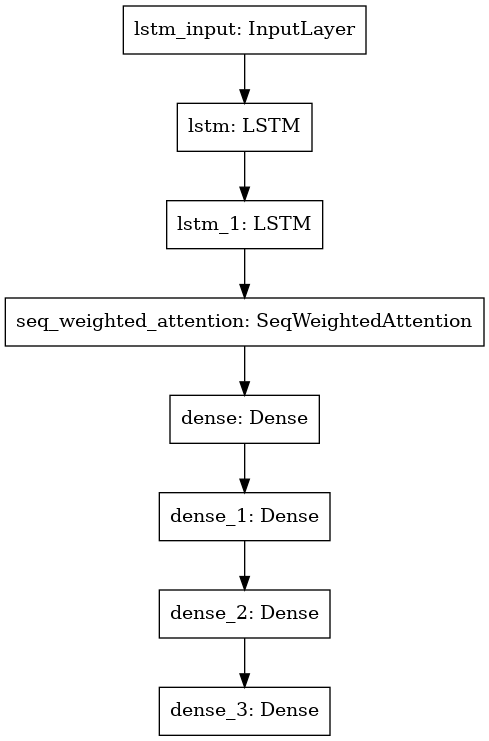

In [11]:
modelT = modeloA()
modelT.summary()
tf.keras.utils.plot_model(modelT, to_file='multiple_outputs.png')

In [13]:
import math
his=modelT.fit(X, y_enc, validation_data=(X_t, y_Val_enc), epochs=70, verbose=2,batch_size=128)

Epoch 1/70
38302/38302 - 407s - loss: 0.1972 - accuracy: 0.9358 - val_loss: 7.1464 - val_accuracy: 0.6857
Epoch 2/70


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


plt.plot(his.history['loss' ])
plt.plot(his.history[ 'val_loss' ])
plt.title( 'model train vs validation loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' ,  'validation' ], loc= 'upper_right' )
plt.show()

plt.plot(his.history['accuracy' ])
plt.plot(his.history[ 'val_accuracy' ])
plt.title( 'model train vs validation accuracy' )
plt.ylabel( 'accuracy' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' ,  'validation' ], loc= 'upper_right' )
plt.show()


# predict probabilities for test set
yhat_probs = model.predict(X_t, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_t, verbose=0)

yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]

y_Val = y_Val.replace('DDoS',3)
y_Val = y_Val.replace('Benign',0)
y_Val = y_Val.replace('Bot',1)
y_Val = y_Val.replace('Bruteforce',2)
y_Val = y_Val.replace('DoS',4)
y_Val = y_Val.replace('Infilteration',5)
y_Val = y_Val.replace('Web_attack',6)

y_Val_n=y_Val.to_numpy()
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_Val_n, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_Val_n, yhat_classes,average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_Val_n, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_Val_n, yhat_classes,average='macro')
print('F1 score: %f' % f1)

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_t_nn, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)


yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]

y_Test = y_Test.replace('DDoS',3)
y_Test = y_Test.replace('Benign',0)
y_Test = y_Test.replace('Bot',1)
y_Test = y_Test.replace('Bruteforce',2)
y_Test = y_Test.replace('DoS',4)
y_Test = y_Test.replace('Infilteration',5)
y_Test = y_Test.replace('Web_attack',6)

y_Test_n=y_Test.to_numpy()
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_Test_n, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_Test_n, yhat_classes,average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_Test_n, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_Test_n, yhat_classes,average='macro')
print('F1 score: %f' % f1)